In [2]:
import gzip
from io import StringIO

import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier, export_graphviz
# from sklearn.cluster import KMeans
# from sklearn.decomposition import PCA
# from sklearn.metrics import silhouette_score

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 8.0)

In [4]:
columns = ['time', 'missing_info', 'job_id', 'task_index',
           'machine_id', 'event_type', 'user', 'scheduling_class',
           'priority', 'cpu_request', 'memory_request',
           'disk_space_request', 'different_machines_restriction']

fn = 'task_events_part-00001-of-00500.csv.gz'
with gzip.open(fn, 'r') as csv_file:
    df = pd.DataFrame.from_csv(csv_file, header=0, index_col=None)
    df.columns = columns

# cast unnecessary float to int
for col in ['event_type', 'scheduling_class', 'priority']:
    df[col] = df[col].astype(np.int)
    
df.different_machines_restriction = df.different_machines_restriction.astype(bool)

## Decision Trees

In [5]:
event_select = [3, 4, 5]
tf = df[df.event_type.isin(event_select)][['event_type', 'cpu_request', 'memory_request', 'priority', 'scheduling_class']]

### Data Balancing

In [6]:
tf.groupby(tf.event_type).count()

,cpu_request,memory_request,priority,scheduling_class
event_type,,,,
3,501,501,501,501
4,14550,14550,14550,14550
5,8171,8171,8171,8171


In [7]:
m = tf.groupby(tf.event_type).count().min().values[0]

for event in event_select:
    tf[tf.event_type==event] = tf[tf.event_type==event][:m]

tf = tf.dropna(axis=0)

In [8]:
tf.groupby(tf.event_type).count()

,cpu_request,memory_request,priority,scheduling_class
event_type,,,,
3.0,501,501,501,501
4.0,501,501,501,501
5.0,501,501,501,501


In [9]:
event_types = {
    3: 'FAIL',
    4: 'FINISH',
    5: 'KILL',
}
# tf.event_type = tf.event_type.apply(lambda x: event_types[int(x)] if x else x)
# tf.head()

### Classifier

In [8]:
%load_ext gvmagic

In [9]:
resource_features = ['cpu_request', 'memory_request']
prio_features = ['priority', 'scheduling_class']
classifier = ['event_type']

# resource classifier
resource_clf = DecisionTreeClassifier(min_samples_split=20)
resource_clf.fit(tf[resource_features], tf[classifier])

# priority classifier
prio_clf = DecisionTreeClassifier(min_samples_split=20)
prio_clf.fit(tf[prio_features], tf[classifier])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=20, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

### Resource decision tree

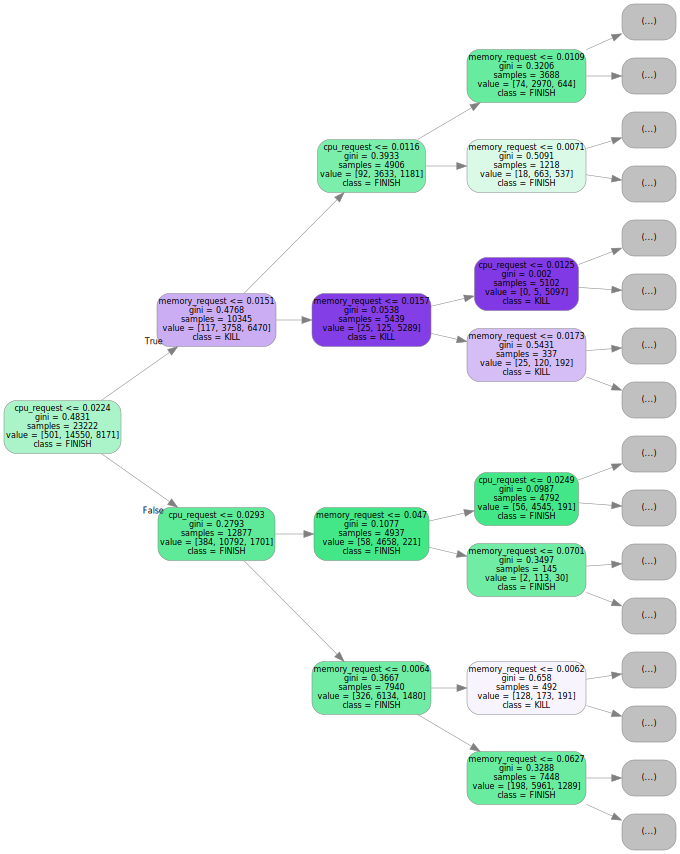

In [10]:
resource_dot = StringIO()

export_graphviz(resource_clf, 
                feature_names=resource_features, 
                class_names=list(event_types.values()),
                rotate=True, 
                rounded=True, 
                filled=True, 
                out_file=resource_dot, 
                max_depth=3)

%dotobj resource_dot

### Priority decision tree

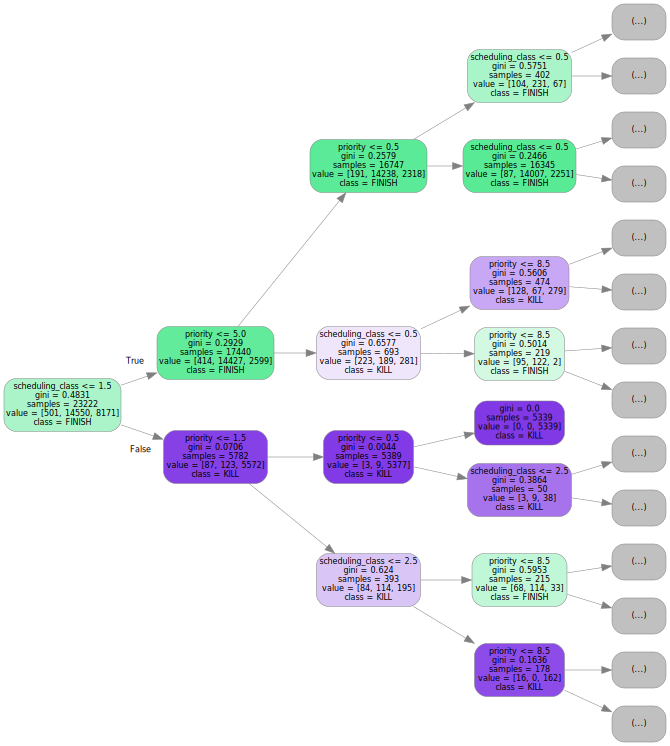

In [11]:
prio_dot = StringIO()

export_graphviz(prio_clf, 
                feature_names=prio_features, 
                class_names=list(event_types.values()),
                rotate=True, 
                rounded=True, 
                filled=True, 
                out_file=prio_dot, 
                max_depth=3)

%dotobj prio_dot

## SVM

### Data normalization

In [10]:
scaler = preprocessing.MinMaxScaler()

In [11]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X = tf[['cpu_request', 'memory_request', 'priority', 'scheduling_class']].values
y = tf.event_type.values
X_new = SelectKBest(chi2, k=2).fit_transform(X, y)
X_new.shape

(1503, 2)

In [12]:
X

array([[  2.49900000e-02,   3.33900000e-02,   2.00000000e+00,
          0.00000000e+00],
       [  2.49900000e-02,   3.33900000e-02,   2.00000000e+00,
          0.00000000e+00],
       [  1.87400000e-02,   1.24400000e-02,   0.00000000e+00,
          3.00000000e+00],
       ..., 
       [  3.12500000e-02,   2.79500000e-02,   9.00000000e+00,
          1.00000000e+00],
       [  6.25000000e-02,   6.21800000e-03,   9.00000000e+00,
          0.00000000e+00],
       [  6.25000000e-02,   6.21800000e-03,   9.00000000e+00,
          0.00000000e+00]])

In [13]:
X_new

array([[ 2.,  0.],
       [ 2.,  0.],
       [ 0.,  3.],
       ..., 
       [ 9.,  1.],
       [ 9.,  0.],
       [ 9.,  0.]])

In [13]:
# pca = PCA(n_components=1)
# X = pca.fit_transform(tf[['cpu_request', 'memory_request', 'priority', 'scheduling_class']].values)
# X_data = tf[['priority', 'scheduling_class']].values
# y = tf.event_type.values

In [14]:
X = scaler.fit_transform(X_new)

In [361]:
X_normalized = preprocessing.normalize(X, norm='l2')
X_normalized

array([[ 1.        ,  0.        ],
       [ 1.        ,  0.        ],
       [ 0.        ,  1.        ],
       ..., 
       [ 0.92609236,  0.37729689],
       [ 1.        ,  0.        ],
       [ 1.        ,  0.        ]])

In [16]:
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.grid_search import GridSearchCV

In [13]:
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(y, n_iter=5, test_size=0.2, random_state=42)
grid = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=cv)
grid.fit(X, y)

GridSearchCV(cv=StratifiedShuffleSplit(labels=[ 4.  4. ...,  3.  3.], n_iter=5, test_size=0.2, random_state=42),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'gamma': array([  1.00000e-09,   1.00000e-08,   1.00000e-07,   1.00000e-06,
         1.00000e-05,   1.00000e-04,   1.00000e-03,   1.00000e-02,
         1.00000e-01,   1.00000e+00,   1.00000e+01,   1.00000e+02,
         1.00000e+03]), 'C': array([  1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02,   1.00000e+03,   1.00000e+04,   1.00000e+05,
         1.00000e+06,   1.00000e+07,   1.00000e+08,   1.00000e+09,
         1.00000e+10])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [14]:
print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

The best parameters are {'gamma': 1.0, 'C': 1000.0} with a score of 0.83


In [ ]:
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(y, n_iter=5, test_size=0.2, random_state=42)
grid = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=cv)
grid.fit(X, y)

In [420]:
print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

The best parameters are {'gamma': 1.0, 'C': 1000.0} with a score of 0.83


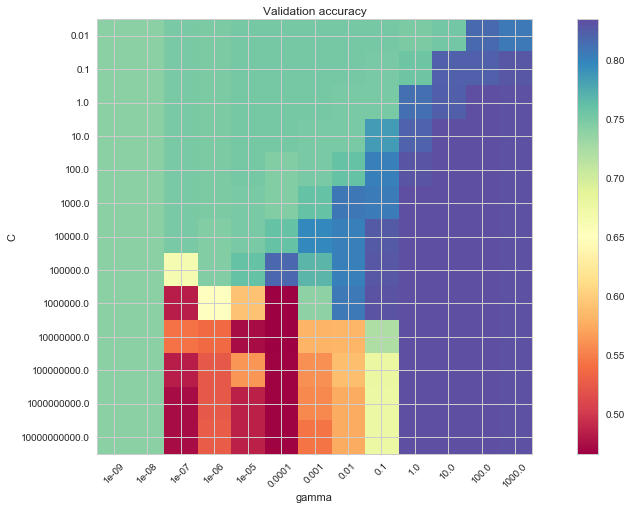

In [436]:
scores = [x[1] for x in grid.grid_scores_]
scores = np.array(scores).reshape(len(C_range), len(gamma_range))

plt.imshow(scores, interpolation='nearest', cmap=plt.cm.Spectral)
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('Validation accuracy')

In [22]:
C = 1000
lin_svc = svm.LinearSVC(C=C).fit(X, y)
svc = svm.SVC(kernel='linear', C=C).fit(X, y)
poly_svc = svm.SVC(kernel='poly', degree=3, C=C).fit(X, y)
rbf_svc = svm.SVC(kernel='rbf', gamma=1, C=C).fit(X, y)

In [23]:
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))

In [20]:
Z = poly_svc.predict(np.c_[xx.ravel(), yy.ravel()])

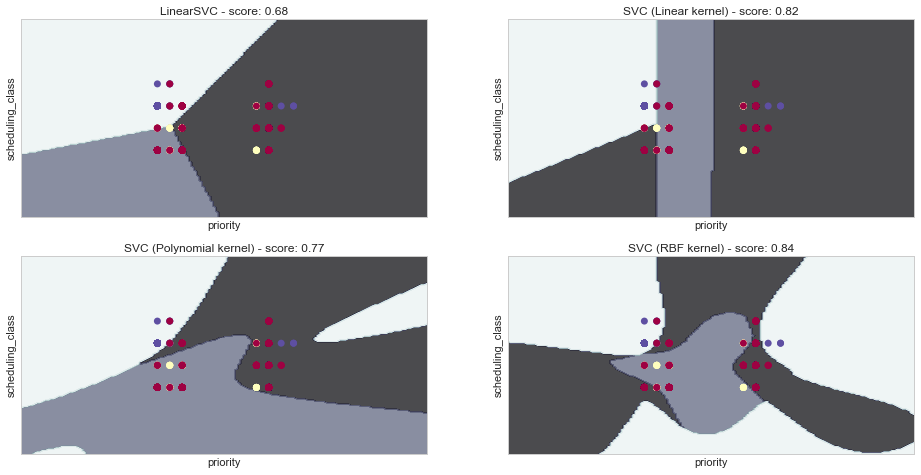

In [51]:
classifiers = ['LinearSVC', 'SVC (Linear kernel)', 'SVC (Polynomial kernel)', 'SVC (RBF kernel)']
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)

for i, clf in enumerate([lin_svc, svc, poly_svc, rbf_svc]):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    axis = ax[int(i/2)][i % 2]
    axis.contourf(xx, yy, Z, alpha=0.75, cmap=plt.cm.bone)
    axis.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
    
    axis.set_title('{} - score: {:.2f}'.format(classifiers[i], clf.score(X, y)))
    axis.set_xlabel('priority')
    axis.set_ylabel('scheduling_class')
    axis.set_xlim(xx.min(), xx.max())
    axis.set_ylim(yy.min(), yy.max())
    axis.set_xticks(())
    axis.set_yticks(())

In [59]:
X

array([[ 0.18181818,  0.        ],
       [ 0.18181818,  0.        ],
       [ 0.        ,  1.        ],
       ..., 
       [ 0.81818182,  0.33333333],
       [ 0.81818182,  0.        ],
       [ 0.81818182,  0.        ]])

In [56]:
rbf_svc.get_params()

{'C': 1000,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': None,
 'degree': 3,
 'gamma': 1,
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [58]:
np.c_[xx.ravel(), yy.ravel()].shape

(22500, 2)

In [ ]:
for i, label in enumerate(est.labels_):
    clusters = clusters.append({
            'cluster': label,
            'event_type': resource_df[['event_type']].values[i][0],
            'cpu_request': features[i][0],
            'memory_request': features[i][1],
        }, ignore_index=True)

## K-Means

In [254]:
resource_df = df[df.event_type.isin(event_select)][['event_type', 'cpu_request', 'memory_request', 'priority', 'scheduling_class']][:1000]
features = resource_df[['event_type', 'priority', 'scheduling_class']].values

for n in range(2, 14):
    est = KMeans(n)
    est.fit(features)
    print(n, silhouette_score(data, est.labels_, metric='euclidean'))

2 0.465120139274
3 0.455225193651
4 0.0718381696015
5 0.135104818155
6 0.191099442606
7 0.264059383749
8 0.269236651772
9 0.175421362751
10 0.153086305761
11 0.0228123607252
12 0.0412649105766
13 0.00486547504379


In [255]:
est = KMeans(3)
est.fit(features)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

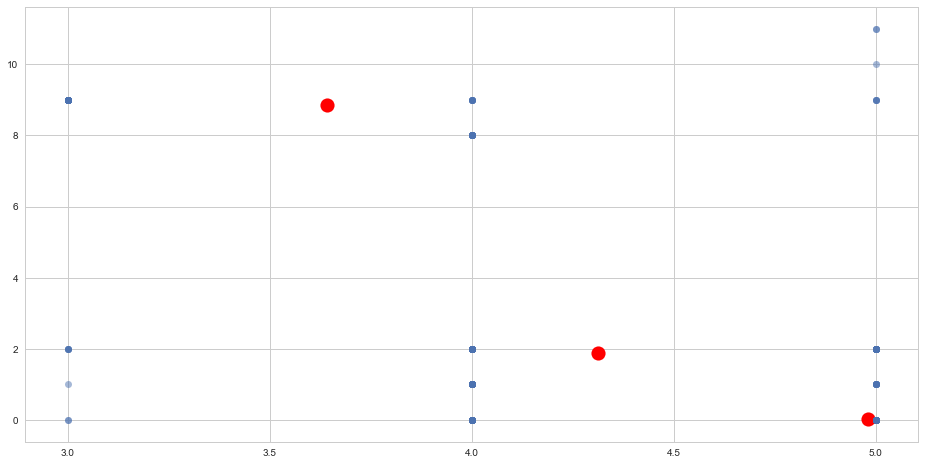

In [256]:
centroids = est.cluster_centers_

plt.scatter(centroids[:, 0], centroids[:, 1], s=200, c='r')
plt.scatter(features[:, 0], features[:, 1], alpha=.5)

In [260]:
est.fit_predict?

In [249]:
clusters = pd.DataFrame(columns=['cluster', 'event_type', 'cpu_request', 'memory_request'])

for i, label in enumerate(est.labels_):
    clusters = clusters.append({
            'cluster': label,
            'event_type': resource_df[['event_type']].values[i][0],
            'cpu_request': features[i][0],
            'memory_request': features[i][1],
        }, ignore_index=True)

clusters.cluster = clusters.cluster.apply(lambda x: round(x))
clusters.event_type = clusters.event_type.apply(lambda x: round(x))

In [251]:
clusters.head()

,cluster,event_type,cpu_request,memory_request
0,0,4,2.0,0.0
1,0,4,2.0,0.0
2,1,5,0.0,3.0
3,1,5,0.0,2.0
4,1,5,0.0,2.0


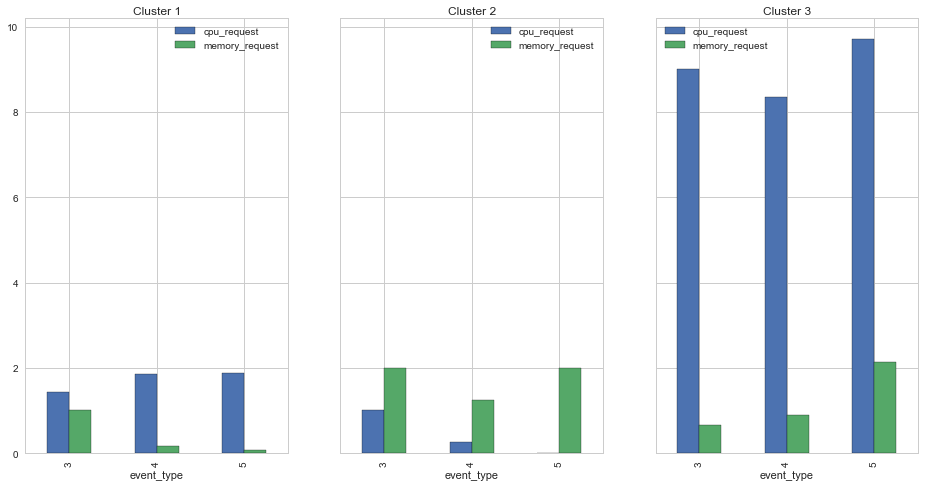

In [253]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True)
for i in range(3):
    clusters[clusters.cluster==i][['cpu_request', 'memory_request']].groupby(clusters.event_type).mean().plot(kind='bar', ax=axes[i])
    axes[i].set_title('Cluster %s' % str(i + 1))